# Residual creation
In this notebook I will work on creating the residual portfolios based on the historical price dataset.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

%reload_ext autoreload
%autoreload 2

In [13]:
import os
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

returns = price_df.pct_change(1)

In [182]:
import os
# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES
filename = 'wrds_daily_returns.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[dt.datetime(2020,12,31):dt.datetime(2023,12,31)]
price_df = price_df.replace(['C','B'],np.nan).astype(float)
price_df.dropna(axis=1,how='any', inplace=True)

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_34753/506956433.py:5: DtypeWarning: Columns (21,41,83,93,98,103,118,155,161,171,196,197,236,243,248,253,266,274,278,288,312,330,346,372,409,422,434,439,449,464,470,487,489,490,494,495,506,524,539,549,550,581,583,611,615,616,618,630,634,635,662,710,725,726,728,729,732,742,751,760,769,782,785,794,817,818,834,838,880,881,923,937,960,1001,1002,1007,1022,1094,1112,1126,1151,1155,1171,1172,1177,1178,1179) have mixed types. Specify dtype option on import or set low_memory=False.
  price_df = pd.read_csv(filename)


In [183]:
import yfinance
SPY = yfinance.download(tickers='SPY',start=dt.datetime(2020,12,30), end=dt.datetime(2023,12,31))
SPY = SPY['Close'].pct_change(1)
SPY.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'SCREE plot')

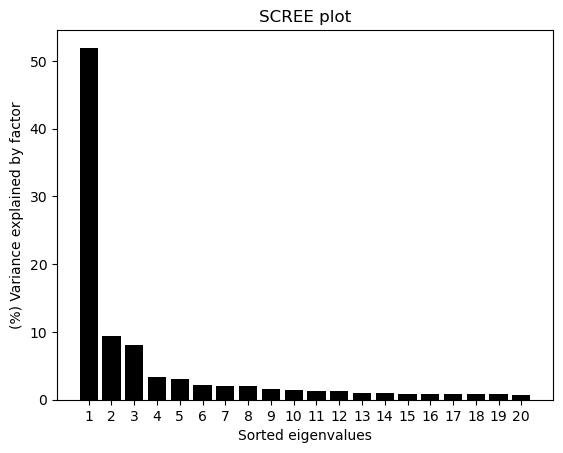

In [289]:
res_cov_window    = price_df.values
amount_of_factors = 5
res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
res_normalized = (res_cov_window - res_mean) / (res_vol+1e-6)
Corr = np.dot(res_normalized.T, res_normalized) / 503.93351729845364
eigenValues, eigenVectors = np.linalg.eigh(Corr)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
R           = res_cov_window
wtR         = res_cov_window @ w                  # R * w 
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ w.T)
#TODO: is ther somethign wrong with the returns they use here??
residuals   = phi @ R.T
mimicking   = beta @ w.T @ R.T

vals = eigenValues / len(eigenValues) * 100
vals = list(reversed(vals))
plt.bar(np.arange(1,21), vals[:20], color='k')
plt.ylabel('(%) Variance explained by factor')
plt.xticks(np.arange(1,21))
plt.xlabel('Sorted eigenvalues')
plt.title('SCREE plot')


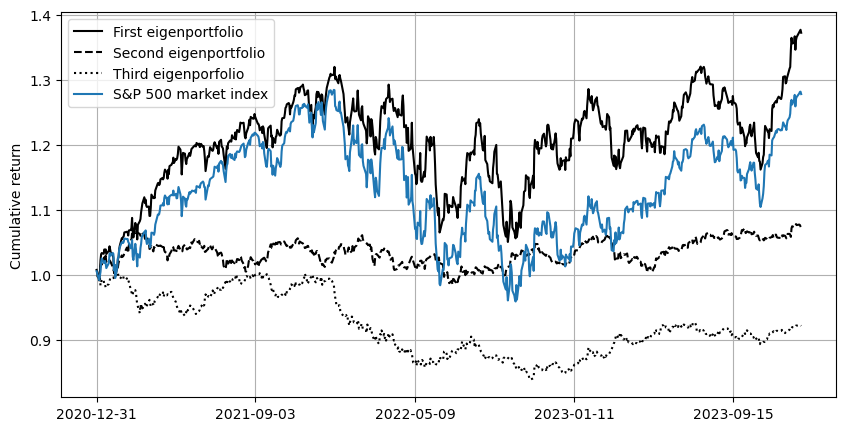

In [297]:
plt.figure(figsize=(10, 5))

vec1 = R @ eigenVectors[:,-1]
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(vec1.reshape(-1,1),SPY.values)
beta        = regr.coef_  
plt.plot(SPY.index.values, (vec1*beta+1).cumprod(), color='black')

vec2 = R @ eigenVectors[:,-2]
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(vec2.reshape(-1,1),SPY.values)
beta2        = regr.coef_  
plt.plot(SPY.index.values, (vec2*beta2+1).cumprod(),'--', color='black')

vec3 = R @ eigenVectors[:,-3]
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(vec3.reshape(-1,1),SPY.values)
beta3        = regr.coef_  
plt.plot(SPY.index.values, (vec3*beta3+1).cumprod(),':', color='black')

plt.plot(SPY.index.values, (SPY+1).cumprod().values)
plt.xticks(SPY.index.values[::170])
plt.legend(['First eigenportfolio','Second eigenportfolio','Third eigenporfolio', 'S&P 500 market index'])
plt.ylabel('Cumulative return')
plt.grid(True)
plt.show()

In [268]:
from tqdm import tqdm 
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.full((T, N), np.nan, dtype=float)
    mimicking_output    = np.full((T, N), np.nan, dtype=float)    

    residual_portfolio  = np.full((T, N, N), np.nan,dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[(t- res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / (res_vol+1e-6)
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        mim          = beta @ w.T @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        mimicking_output[t:(t+1),idxsSelected]                = mim
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio, mimicking_output

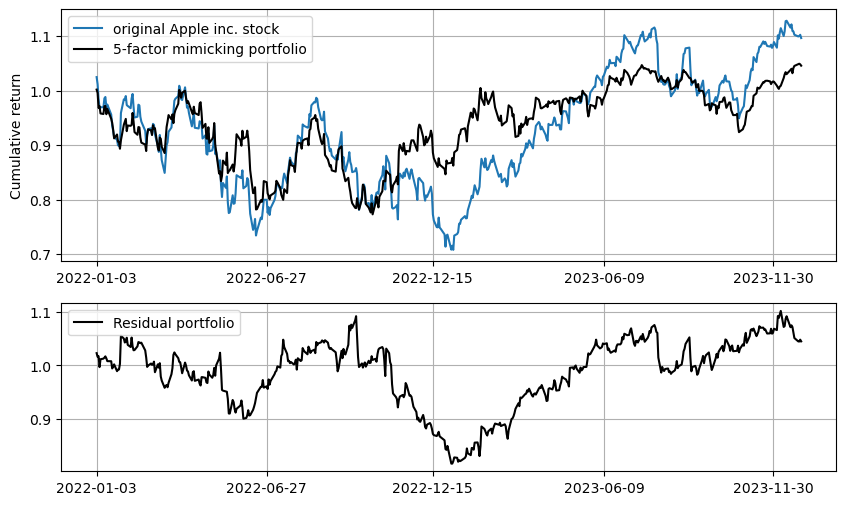

In [296]:
#res_out, res_portf, mim_portf = pca(price_df, amount_of_factors=5)

res_oos = pd.DataFrame(res_out, index=price_df.index, columns=price_df.columns)
mim_oos = pd.DataFrame(mim_portf, index=price_df.index, columns=price_df.columns)

stock = 'AAPL'
fig, axs = plt.subplots(2, 1, figsize=(10, 6),gridspec_kw={'height_ratios': [1.5,1]})
axs[0].set_ylabel('Cumulative return')
axs[0].plot((price_df.loc[price_df.index[253]:, stock]+1).cumprod())
axs[0].plot((mim_oos[stock]+1).cumprod(), color='k')
axs[0].legend(['original Apple inc. stock', '{}-factor mimicking portfolio'.format(amount_of_factors)])
axs[1].plot((res_oos[stock]+1).cumprod(),'k')
axs[1].legend(['Residual portfolio'])
axs[0].set_xticks(SPY.index[253:].values[::120])
axs[1].set_xticks(SPY.index[253:].values[::120])
axs[0].grid(True)
axs[1].grid(True)
plt.show()

In [75]:
dataset      = pd.DataFrame(res_out, index = returns.loc[dt.datetime(2014,1,1):dt.datetime(2018,1,2)].dropna(axis=0, thresh=300).index ,columns=returns.columns)

In [109]:
import os
import datetime as dt
filename = 'res_rets.csv'
if os.path.exists(filename):
    dataset = pd.read_csv(filename)
    dataset = dataset.rename(columns={'Unnamed: 0':'date'})
    dataset.set_index('date', inplace=True)
    dataset.index = pd.to_datetime(dataset.index)

In [169]:
start_train = dt.datetime(2012,1,1)
end_train   = dt.datetime(2018,1,1)
start_eval  = dt.datetime(2018,1,1)
end_eval    = dt.datetime(2020,1,1)

train_data = dataset.loc[start_train:end_train]
test_data  = dataset.loc[start_eval:end_eval]

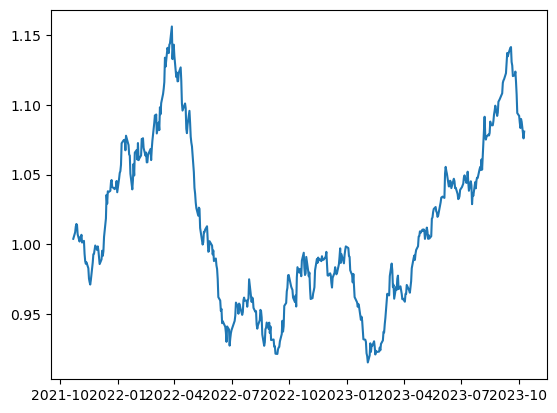

In [170]:
import matplotlib.pyplot as plt
plt.plot((dataset.iloc[253:].tail(500)['BRK.B']+1).cumprod())

In [182]:
import torch
import torch.nn as nn


class CNN_Block(nn.Module):
    def __init__(self, in_filters=1, out_filters=8, normalization=True, filter_size=2):
        super(CNN_Block, self).__init__()  
        self.in_filters = in_filters
        self.out_filters = out_filters
        
        self.conv1 = nn.Conv1d(in_channels=in_filters, out_channels=out_filters, kernel_size=filter_size,
                                    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv2 = nn.Conv1d(in_channels=out_filters, out_channels=out_filters, kernel_size=filter_size,
                                    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu = nn.ReLU(inplace=True)
        self.left_zero_padding = nn.ConstantPad1d((filter_size-1,0),0)
        
        self.normalization1 = nn.InstanceNorm1d(in_filters)
        self.normalization2 = nn.InstanceNorm1d(out_filters)
        self.normalization = normalization
       
    def forward(self, x): #x and out have dims (N,C,T) where C is the number of channels/filters
        if self.normalization:
            x = self.normalization1(x)
        out = self.left_zero_padding(x)
        out = self.conv1(out)
        out = self.relu(out)
        if self.normalization: 
            out = self.normalization2(out)
        out = self.left_zero_padding(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = out + x.repeat(1,int(self.out_filters/self.in_filters),1)   
        return out 

class CNNTransformer(nn.Module):
    def __init__(self, 
                 random_seed = 0, 
                 device = "cpu", # other options for device are e.g. "cuda:0"
                 normalization_conv = True, 
                 filter_numbers = [1,8], 
                 attention_heads = 4, 
                 use_convolution = True,
                 hidden_units = 2*8, 
                 hidden_units_factor = 2,
                 dropout = 0.25, 
                 filter_size = 2, 
                 use_transformer = True):
        
        super(CNNTransformer, self).__init__()
        if hidden_units and hidden_units_factor and hidden_units != hidden_units_factor * filter_numbers[-1]:
            raise Exception(f"`hidden_units` conflicts with `hidden_units_factor`; provide one or the other, but not both.")
        if hidden_units_factor:
            hidden_units = hidden_units_factor * filter_numbers[-1]
        self.random_seed = random_seed 
        torch.manual_seed(self.random_seed)
        self.device = torch.device(device)
        self.filter_numbers = filter_numbers
        self.use_transformer = use_transformer
        self.use_convolution = use_convolution and len(filter_numbers) > 0
        self.is_trainable = True
        
        self.convBlocks = nn.ModuleList()
        for i in range(len(filter_numbers)-1):
            self.convBlocks.append(
                CNN_Block(filter_numbers[i],filter_numbers[i+1],normalization=normalization_conv,filter_size=filter_size))
        self.encoder = nn.TransformerEncoderLayer(d_model=filter_numbers[-1], nhead=attention_heads, dim_feedforward=hidden_units, dropout=dropout)
        self.linear = nn.Linear(filter_numbers[-1],1)
        #self.softmax = nn.Sequential(nn.Linear(filter_numbers[-1],num_classes))#,nn.Softmax(dim=1))
                 
    def forward(self,x): #x has dimension (N,T)
        N,T = x.shape
        x = x.reshape((N,1,T))  #(N,1,T)
        if self.use_convolution:
            for i in range(len(self.filter_numbers)-1):
                x = self.convBlocks[i](x) #(N,C,T), C is the number of channels/features
        x = x.permute(2,0,1)
        if self.use_transformer:
            x = self.encoder(x) #the input of the transformer is (T,N,C)
        return self.linear(x[-1,:,:]).squeeze() #this outputs the weights #self.softmax(x[-1,:,:]) #(N,num_classes)

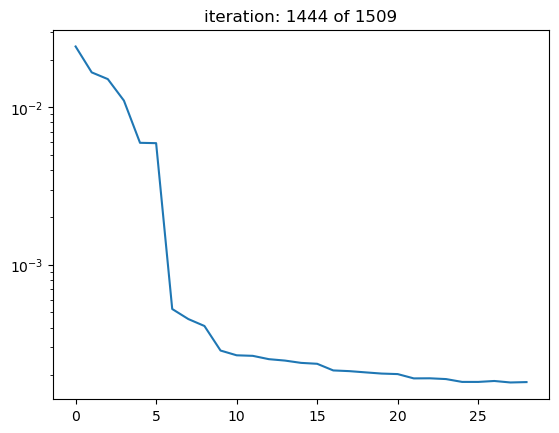

In [185]:
from tqdm import tqdm
from collections import deque
from IPython.display import clear_output
import random

model     = CNNTransformer()
lookback  = 60
begin_idx = 252
# initializing the model
optimizer_opts = {'lr':0.01}
model.train()
optimizer = torch.optim.Adam(model.parameters(), **optimizer_opts)
mse       = nn.MSELoss()
losses    = deque(maxlen=200)
loss_graph = list()
shuffled_idxs = random.sample(list(range(lookback + 1,len(train_data)-1)), len(list(range(lookback + 1,len(train_data)-1))))
for iter, idx in enumerate(shuffled_idxs):
    window    = (train_data.iloc[idx - lookback: idx+1]).values
    idxsSelected = ~np.any(np.isnan(window), axis = 0).ravel()
    if idxsSelected.sum() == 0:
        continue
    inputVars = torch.FloatTensor((window[:-1,idxsSelected]+1).cumprod(axis=0).T)
    target    = torch.FloatTensor(window[-1,idxsSelected].T)

    pred      = model.forward(inputVars)
    loss      = mse(pred,target)
    
    losses.append(loss.item())
    if idx % 50 == 0:
        loss_graph.append(np.mean(losses))
        clear_output(True)
        plt.plot(loss_graph)
        plt.yscale('log')
        plt.title('iteration: {} of {}'.format(iter, len(train_data)))
        plt.show()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
class InfusedPredictionModule():
    def __init__(self,**kwargs) -> None:
        self.lookback   = kwargs['lookback']
        # initializing the model
        self.optimizer_opts = {'lr':0.01}
        self.mse       = nn.MSELoss()
        self.losses    = deque(maxlen=200)
        self.loss_graph = list()
        self.reset()

    def reset(self):
        self.model = CNNTransformer()
        self.optimizer = torch.optim.Adam(model.parameters(), **self.optimizer_opts)
    
    def train(self, train_data=pd.DataFrame):
        shuffled_idxs = random.sample(list(range(self.lookback + 1,len(train_data)-1)), len(list(range(self.lookback + 1,len(train_data)-1))))
        # training loop for training the vision transformer model
        for iter, idx in enumerate(shuffled_idxs):
            window    = (train_data.iloc[idx - self.lookback: idx+1]+1).cumprod().values
            idxsSelected = ~np.any(np.isnan(window), axis = 0).ravel()
            if idxsSelected.sum() == 0:
                continue
            inputVars = torch.FloatTensor(window[:-1,idxsSelected].T)
            target    = torch.FloatTensor(window[-1,idxsSelected].T)

            pred      = model.forward(inputVars)
            loss      = mse(pred,target)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Finished training the prediction module')
        model.eval()
    
    def predict(self, residuals_data = pd.DataFrame):
        L, N = residuals_data.shape
        res_window = (residuals_data + 1).cumprod().values[1:,:] 
        return self.model(torch.FloatTensor(res_window.reshape(1,-1)))

In [179]:
model

CNNTransformer(
  (convBlocks): ModuleList(
    (0): CNN_Block(
      (conv1): Conv1d(1, 8, kernel_size=(2,), stride=(1,))
      (conv2): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
      (relu): ReLU(inplace=True)
      (left_zero_padding): ConstantPad1d(padding=(1, 0), value=0)
      (normalization1): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (normalization2): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=16, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (linear2): Linear(in_features=16, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.25

100%|██████████| 441/441 [00:38<00:00, 11.48it/s] 


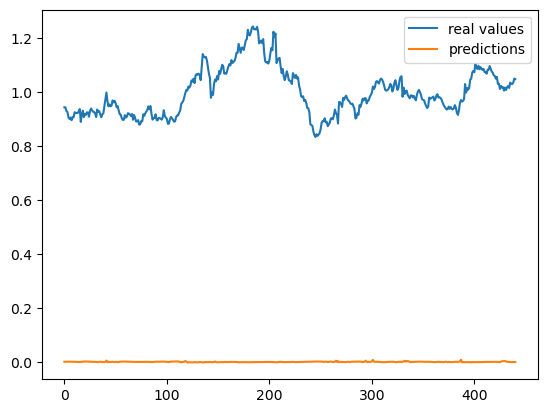

In [186]:
test_asset = 'CAT'
asset_data = test_data[test_asset].values
model.eval()
targets  = []
predictions = []
for idx in tqdm(range(lookback + 1,len(test_data)-1)):
    window    = (asset_data[idx-lookback:idx+1] + 1).cumprod()
    inputVars = window[:-1]
    target    = window[-1]
    pred = model(torch.FloatTensor(inputVars.reshape(1,-1)))
    targets.append(target)
    predictions.append(pred.item())

plt.plot(targets)
plt.plot(predictions)
plt.legend(['real values', 'predictions'])

In [ ]:
def preprocess_ou(data:np.array, lookback:int=60):
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2

        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
        
    idxs_selected = torch.as_tensor(idxs_selected)
    return windows, idxs_selected